# Example Model Explanations with Seldon

## Prerequisites
You will need
 - [Git clone of Seldon Core](https://github.com/SeldonIO/seldon-core)
 - A running Kubernetes cluster with kubectl authenticated
 - [seldon-core Python package](https://pypi.org/project/seldon-core/) (```pip install seldon-core>=0.2.6.1```)
 - [Helm client](https://helm.sh/)

### Creating a Kubernetes Cluster

Follow the [Kubernetes documentation to create a cluster](https://kubernetes.io/docs/setup/).

Once created ensure ```kubectl``` is authenticated against the running cluster.

## Setup

In [1]:
!kubectl create namespace seldon

namespace/seldon created


In [2]:
!kubectl config set-context $(kubectl config current-context) --namespace=seldon

Context "kubernetes-admin@kind" modified.


In [3]:
!kubectl create clusterrolebinding kube-system-cluster-admin --clusterrole=cluster-admin --serviceaccount=kube-system:default

clusterrolebinding.rbac.authorization.k8s.io/kube-system-cluster-admin created


## Install Helm

In [4]:
!kubectl -n kube-system create sa tiller
!kubectl create clusterrolebinding tiller --clusterrole cluster-admin --serviceaccount=kube-system:tiller
!helm init --service-account tiller

serviceaccount/tiller created
clusterrolebinding.rbac.authorization.k8s.io/tiller created
$HELM_HOME has been configured at /home/clive/.helm.

Tiller (the Helm server-side component) has been installed into your Kubernetes Cluster.

Please note: by default, Tiller is deployed with an insecure 'allow unauthenticated users' policy.
To prevent this, run `helm init` with the --tiller-tls-verify flag.
For more information on securing your installation see: https://docs.helm.sh/using_helm/#securing-your-helm-installation
Happy Helming!


In [5]:
!kubectl rollout status deploy/tiller-deploy -n kube-system

Waiting for deployment "tiller-deploy" rollout to finish: 0 of 1 updated replicas are available...
deployment "tiller-deploy" successfully rolled out


## Start seldon-core

In [11]:
!helm install ../helm-charts/seldon-core-operator --name seldon-core --set image.pullPolicy=Never --set usageMetrics.enabled=true --namespace seldon-system

NAME:   seldon-core
LAST DEPLOYED: Thu Oct  3 08:55:17 2019
NAMESPACE: seldon-system
STATUS: DEPLOYED

RESOURCES:
==> v1/ClusterRole
NAME                     AGE
seldon-manager-css-role  1s
seldon-manager-role      1s
seldon-manager-sas-role  1s
seldon-proxy-role        1s

==> v1/ClusterRoleBinding
NAME                            AGE
seldon-manager-css-rolebinding  1s
seldon-manager-rolebinding      1s
seldon-manager-sas-rolebinding  1s
seldon-proxy-rolebinding        1s

==> v1/ConfigMap
NAME                     DATA  AGE
seldon-config            1     1s
seldon-spartakus-config  1     1s

==> v1/Deployment
NAME                       READY  UP-TO-DATE  AVAILABLE  AGE
seldon-controller-manager  0/1    1           0          1s

==> v1/Pod(related)
NAME                                         READY  STATUS             RESTARTS  AGE
seldon-controller-manager-cb744d8d5-fmlrs    0/1    ContainerCreating  0         1s
seldon-spartakus-volunteer-7d6dd98f89-k2zrx  0/1    ContainerCreating  0

In [ ]:
!kubectl rollout status deployment/seldon-operator-controller-manager -n seldon-system

## Setup Ingress
Please note: There are reported gRPC issues with ambassador (see https://github.com/SeldonIO/seldon-core/issues/473).

In [7]:
!helm install stable/ambassador --name ambassador --set crds.keep=false

NAME:   ambassador
LAST DEPLOYED: Thu Oct  3 08:50:33 2019
NAMESPACE: seldon
STATUS: DEPLOYED

RESOURCES:
==> v1/Deployment
NAME        READY  UP-TO-DATE  AVAILABLE  AGE
ambassador  0/3    3           0          0s

==> v1/Pod(related)
NAME                         READY  STATUS             RESTARTS  AGE
ambassador-5784b5cb9d-22d6x  0/1    ContainerCreating  0         0s
ambassador-5784b5cb9d-rpfjh  0/1    ContainerCreating  0         0s
ambassador-5784b5cb9d-rphfr  0/1    ContainerCreating  0         0s

==> v1/Service
NAME              TYPE          CLUSTER-IP      EXTERNAL-IP  PORT(S)                     AGE
ambassador        LoadBalancer  10.106.236.142  <pending>    80:31168/TCP,443:32161/TCP  0s
ambassador-admin  ClusterIP     10.107.160.45   <none>       8877/TCP                    0s

==> v1/ServiceAccount
NAME        SECRETS  AGE
ambassador  1        0s

==> v1beta1/ClusterRole
NAME             AGE
ambassador       0s
ambassador-crds  0s

==> v1beta1/ClusterRoleBinding
NAME    

In [8]:
!kubectl rollout status deployment.apps/ambassador

Waiting for deployment "ambassador" rollout to finish: 0 of 3 updated replicas are available...
Waiting for deployment "ambassador" rollout to finish: 1 of 3 updated replicas are available...
Waiting for deployment "ambassador" rollout to finish: 2 of 3 updated replicas are available...
deployment "ambassador" successfully rolled out


### Port Forward to Ambassador

```
kubectl port-forward $(kubectl get pods -n seldon -l app.kubernetes.io/name=ambassador -o jsonpath='{.items[0].metadata.name}') -n seldon 8003:8080
```

## Income Prediction Model

In [1]:
!pygmentize resources/income_explainer.yaml

apiVersion: machinelearning.seldon.io/v1alpha2
kind: SeldonDeployment
metadata:
  name: income
spec:
  name: income
  predictors:
  - graph:
      children: []
      implementation: SKLEARN_SERVER
      modelUri: gs://seldon-models/sklearn/income/model
      name: classifier
    explainer:
      type: anchor_tabular
      modelUri: gs://seldon-models/sklearn/income/explainer
    name: default
    replicas: 1


In [8]:
!kubectl apply -f resources/income_explainer.yaml

seldondeployment.machinelearning.seldon.io/income created


In [9]:
!kubectl rollout status deploy/income-default-4903e3c

Waiting for deployment "income-default-4903e3c" rollout to finish: 0 of 1 updated replicas are available...
deployment "income-default-4903e3c" successfully rolled out


In [10]:
from seldon_core.seldon_client import SeldonClient
import numpy as np
sc = SeldonClient(deployment_name="income",namespace="seldon")

In [11]:
data = np.array([[39, 7, 1, 1, 1, 1, 4, 1, 2174, 0, 40, 9]])
r = sc.predict(gateway="ambassador",transport="rest",data=data)
print(r)

Success:True message:
Request:
data {
  tensor {
    shape: 1
    shape: 12
    values: 39.0
    values: 7.0
    values: 1.0
    values: 1.0
    values: 1.0
    values: 1.0
    values: 4.0
    values: 1.0
    values: 2174.0
    values: 0.0
    values: 40.0
    values: 9.0
  }
}

Response:
meta {
  puid: "8qs8ieo9jp79i5bjs63nc1n6bk"
  requestPath {
    key: "classifier"
    value: "seldonio/sklearnserver_rest:0.2"
  }
}
data {
  names: "t:0"
  names: "t:1"
  tensor {
    shape: 1
    shape: 2
    values: 1.0
    values: 0.0
  }
}



In [12]:
data = np.array([[39, 7, 1, 1, 1, 1, 4, 1, 2174, 0, 40, 9]])
explanation = sc.explain(deployment_name="income",gateway="ambassador",transport="rest",data=data)
print(explanation["names"])

['Marital Status = Never-Married', 'Hours per week <= 40.00']


In [13]:
!kubectl delete -f resources/income_explainer.yaml

seldondeployment.machinelearning.seldon.io "income" deleted


## Movie Sentiment Model



In [14]:
!pygmentize resources/moviesentiment_explainer.yaml

apiVersion: machinelearning.seldon.io/v1alpha2
kind: SeldonDeployment
metadata:
  name: movie
spec:
  name: movie
  predictors:
  - graph:
      children: []
      implementation: SKLEARN_SERVER
      modelUri: gs://seldon-models/sklearn/moviesentiment
      name: classifier
    explainer:
      type: anchor_text
    name: default
    replicas: 1


In [15]:
!kubectl apply -f resources/moviesentiment_explainer.yaml

seldondeployment.machinelearning.seldon.io/movie created


In [16]:
!kubectl rollout status deploy/movie-default-4903e3c

Waiting for deployment "movie-default-4903e3c" rollout to finish: 0 of 1 updated replicas are available...
deployment "movie-default-4903e3c" successfully rolled out


In [17]:
from seldon_core.seldon_client import SeldonClient
import numpy as np
sc = SeldonClient(deployment_name="movie",namespace="seldon")

In [18]:
data = np.array(['this film has great actors'])
r = sc.predict(gateway="ambassador",transport="rest",data=data,payload_type='ndarray')
print(r)

Success:True message:
Request:
data {
  ndarray {
    values {
      string_value: "this film has great actors"
    }
  }
}

Response:
meta {
  puid: "re1drvdqoppisg1cl42aib3abc"
  requestPath {
    key: "classifier"
    value: "seldonio/sklearnserver_rest:0.2"
  }
}
data {
  names: "t:0"
  names: "t:1"
  ndarray {
    values {
      list_value {
        values {
          number_value: 0.21266916924914636
        }
        values {
          number_value: 0.7873308307508536
        }
      }
    }
  }
}



In [19]:
data = np.array(['this film has great actors'])
explanation = sc.explain(deployment_name="movie",gateway="ambassador",transport="rest",data=data,payload_type='ndarray')
print(explanation)

{'names': ['great'], 'precision': 1.0, 'coverage': 0.5007, 'raw': {'feature': [3], 'mean': [1.0], 'precision': [1.0], 'coverage': [0.5007], 'examples': [{'covered': [['this film UNK great UNK'], ['UNK film has great actors'], ['UNK film UNK great actors'], ['this UNK has great UNK'], ['this film UNK great UNK'], ['this UNK has great UNK'], ['UNK UNK UNK great actors'], ['UNK film has great actors'], ['UNK film UNK great UNK'], ['UNK UNK UNK great actors']], 'covered_true': [['UNK film UNK great UNK'], ['UNK UNK has great UNK'], ['UNK UNK UNK great actors'], ['UNK UNK has great UNK'], ['this UNK UNK great UNK'], ['UNK film UNK great actors'], ['this UNK has great UNK'], ['this UNK UNK great UNK'], ['UNK film has great actors'], ['this film UNK great UNK']], 'covered_false': [], 'uncovered_true': [], 'uncovered_false': []}], 'all_precision': 0, 'num_preds': 1000101, 'names': ['great'], 'positions': [14], 'instance': 'this film has great actors', 'prediction': 1}}


In [20]:
!kubectl delete -f resources/moviesentiment_explainer.yaml

seldondeployment.machinelearning.seldon.io "movie" deleted


## Imagenet Model



In [68]:
!pygmentize resources/imagenet_explainer_grpc.yaml

apiVersion: machinelearning.seldon.io/v1alpha2
kind: SeldonDeployment
metadata:
  name: image
spec:
  annotations:
    seldon.io/rest-read-timeout: "10000000"
    seldon.io/grpc-read-timeout: "10000000"
    seldon.io/grpc-max-message-size: "1000000000"
  name: image
  predictors:
  - componentSpecs:
    - spec:
        containers:
        - image: docker.io/seldonio/imagenet-transformer:0.1
          name: transformer
    graph:
      name: transformer
      type: TRANSFORMER
      endpoint:
        type: GRPC
      children: 
      - implementation: TENSORFLOW_SERVER
        modelUri: gs://seldon-models/tfserving/imagenet/model
        name: classifier
        endpoint:
          type: GRPC
        parameters:
          - name: model_name
            type: STRING
            value: classifier
          - name: model_input
            type: STRING
            value: input_image
          - name: model_output
            type: STRING
            value: predictions/Softmax:0
    engineRe

In [69]:
!kubectl apply -f resources/imagenet_explainer_grpc.yaml

seldondeployment.machinelearning.seldon.io/image created


In [71]:
!kubectl rollout status deploy/image-default-5d14729

Waiting for deployment "image-default-5d14729" rollout to finish: 0 of 1 updated replicas are available...
deployment "image-default-5d14729" successfully rolled out


In [72]:
from PIL import Image
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from tensorflow.keras.applications.inception_v3 import InceptionV3, decode_predictions
import alibi
from alibi.datasets import fetch_imagenet
import numpy as np

def get_image_data():
    data = []
    image_shape = (299, 299, 3)
    target_size = image_shape[:2]
    image = Image.open("cat-raw.jpg").convert('RGB')
    image = np.expand_dims(image.resize(target_size), axis=0)
    data.append(image)
    data = np.concatenate(data, axis=0)
    return data

data = get_image_data()

In [73]:
from seldon_core.seldon_client import SeldonClient
import numpy as np
sc = SeldonClient(deployment_name="image",namespace="seldon",grpc_max_send_message_length= 27 * 1024 * 1024,grpc_max_receive_message_length= 27 * 1024 * 1024)

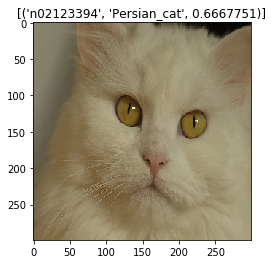

In [74]:
import tensorflow as tf
data = get_image_data()
req = data[0:1]
r = sc.predict(gateway="ambassador",transport="grpc",data=req,payload_type='tftensor')
preds = tf.make_ndarray(r.response.data.tftensor)

label = decode_predictions(preds, top=1)
plt.title(label[0])
plt.imshow(data[0])

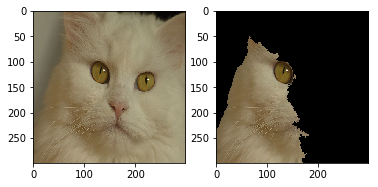

In [75]:
req = np.expand_dims(data[0], axis=0)
explanation = sc.explain(deployment_name="image",gateway="ambassador",transport="rest",data=req)
exp_arr = np.array(explanation['anchor'])

f, axarr = plt.subplots(1, 2)
axarr[0].imshow(data[0])
axarr[1].imshow(explanation['anchor'])
plt.show()


In [33]:
!kubectl delete -f resources/imagenet_explainer_grpc.yaml

seldondeployment.machinelearning.seldon.io "image" deleted
